<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/1_Eksperimen_HDBSCAN_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hdbscan -q

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import hdbscan

from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
print("Semua library sudah aman")

Semua library sudah aman


In [ ]:
drive.mount('/content/drive')
print("Drive juga amanmi")

Mounted at /content/drive
Drive juga amanmi


In [ ]:
EMBEDDINGS_PATH = "/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl"

OUTPUT_DIR = "/content/drive/MyDrive/OTW S.KOM/Eksperiment"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Test Konfiguraisnya")
print(f"  - Embeddings path: {EMBEDDINGS_PATH}")
print(f"  - Output directory: {OUTPUT_DIR}")

Test Konfiguraisnya
  - Embeddings path: /content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl
  - Output directory: /content/drive/MyDrive/OTW S.KOM/Eksperiment


In [ ]:
def load_embeddings(file_path):
  with open(file_path, 'rb') as f:
    data = pickle.load(f)

  embeddings = data['embeddings']
  metadata = data['metadata']
  stats = data['stats']

  print("Embedding sukses dibaca")
  print(f"  - Shape : {embeddings.shape}")
  print(f"  - Total faces : {len(metadata)}")

  return embeddings, metadata, stats

embeddings, metadata, stats = load_embeddings(EMBEDDINGS_PATH)

print(f"/n Rangkuman dataset : ")
print(f"  - Data points (faces) : {embeddings.shape[0]}")
print(f"  - Dimensions          : {embeddings.shape[1]}")
print(f"  - Original images     : {stats['total_images']}")
print(f"  - Images with faces   : {stats['images_with_faces']}")

Embedding sukses dibaca
  - Shape : (12715, 512)
  - Total faces : 12715
/n Rangkuman dataset : 
  - Data points (faces) : 12715
  - Dimensions          : 512
  - Original images     : 2533
  - Images with faces   : 2365


In [ ]:
def run_hdbscan_clustering(embeddings, min_cluster_size=15, min_samples=None,
                            metric='euclidean', cluster_selection_method='eom'):
    """
    Menjalankan HDBSCAN clustering pada embeddings.

    Parameters:
    -----------
    embeddings : np.ndarray
        Face embeddings dengan shape (n_samples, 512)
    min_cluster_size : int
        Minimum jumlah sampel dalam satu cluster
    min_samples : int or None
        Jumlah sampel dalam neighborhood untuk core points.
        Jika None, akan sama dengan min_cluster_size.
    metric : str
        Distance metric yang digunakan ('euclidean', 'manhattan', dll)
    cluster_selection_method : str
        Metode seleksi cluster: 'eom' (Excess of Mass) atau 'leaf'

    Returns:
    --------
    results : dict
        Dictionary berisi:
        - labels: cluster labels untuk setiap sampel (-1 = noise)
        - n_clusters: jumlah cluster yang terbentuk
        - n_noise: jumlah noise points
        - noise_ratio: persentase noise
        - silhouette_score: Silhouette Score (higher is better)
        - davies_bouldin_index: Davies-Bouldin Index (lower is better)
        - clusterer: HDBSCAN object
        - params: parameter yang digunakan
    """

    # Inisialisasi HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_method=cluster_selection_method,
        core_dist_n_jobs=-1  # Gunakan semua CPU cores
    )

    # Fit dan predict
    labels = clusterer.fit_predict(embeddings)

    # Hitung statistik
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_ratio = n_noise / len(labels) * 100

    # Hitung evaluation metrics
    # Hanya jika ada lebih dari 1 cluster dan tidak semua noise
    if n_clusters > 1:
        # Filter noise untuk evaluasi
        mask = labels != -1
        n_valid = mask.sum()

        if n_valid > n_clusters:  # Pastikan ada cukup sampel
            sil_score = silhouette_score(embeddings[mask], labels[mask])
            db_index = davies_bouldin_score(embeddings[mask], labels[mask])
        else:
            sil_score = -1
            db_index = -1
    else:
        sil_score = -1
        db_index = -1

    # Compile results
    results = {
        'labels': labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': noise_ratio,
        'silhouette_score': sil_score,
        'davies_bouldin_index': db_index,
        'clusterer': clusterer,
        'params': {
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'metric': metric,
            'cluster_selection_method': cluster_selection_method
        }
    }

    return results


def print_clustering_results(results):

    print("\n" + "=" * 60)
    print("📊 CLUSTERING RESULTS")
    print("=" * 60)

    print("\n🔧 Parameters:")
    print(f"   - min_cluster_size: {results['params']['min_cluster_size']}")
    print(f"   - min_samples: {results['params']['min_samples']}")
    print(f"   - metric: {results['params']['metric']}")
    print(f"   - cluster_selection_method: {results['params']['cluster_selection_method']}")

    print("\n📈 Results:")
    print(f"   - Number of clusters: {results['n_clusters']}")
    print(f"   - Noise points: {results['n_noise']} ({results['noise_ratio']:.2f}%)")

    print("\n📏 Evaluation Metrics:")
    if results['silhouette_score'] != -1:
        print(f"   - Silhouette Score: {results['silhouette_score']:.4f} (higher is better)")
        print(f"   - Davies-Bouldin Index: {results['davies_bouldin_index']:.4f} (lower is better)")
    else:
        print("   - Metrics not available (need > 1 cluster with enough samples)")

    print("=" * 60)


def get_cluster_distribution(labels):

    unique, counts = np.unique(labels, return_counts=True)

    distribution = pd.DataFrame({
        'cluster_id': unique,
        'count': counts
    })

    # Sort by count descending
    distribution = distribution.sort_values('count', ascending=False).reset_index(drop=True)

    return distribution


print("✅ HDBSCAN functions defined!")

✅ HDBSCAN functions defined!


In [ ]:
def run_grid_search(embeddings, param_grid, metric='euclidean'):
    """
    Menjalankan Grid Search untuk hyperparameter tuning HDBSCAN.

    Parameters:
    -----------
    embeddings : np.ndarray
        Face embeddings
    param_grid : dict
        Dictionary berisi list nilai untuk setiap parameter:
        - 'min_cluster_size': list of int
        - 'min_samples': list of int or None
        - 'cluster_selection_method': list of str ('eom', 'leaf')
    metric : str
        Distance metric yang digunakan

    Returns:
    --------
    all_results : list
        List berisi semua hasil eksperimen
    best_result : dict
        Hasil terbaik berdasarkan Silhouette Score
    """
    all_results = []

    # Hitung total kombinasi
    total_combinations = (
        len(param_grid['min_cluster_size']) *
        len(param_grid['min_samples']) *
        len(param_grid['cluster_selection_method'])
    )

    print(f"🔍 GRID SEARCH: {metric.upper()} Distance")
    print("=" * 60)
    print(f"   Total combinations: {total_combinations}")
    print(f"   Parameter space:")
    print(f"      - min_cluster_size: {param_grid['min_cluster_size']}")
    print(f"      - min_samples: {param_grid['min_samples']}")
    print(f"      - cluster_selection_method: {param_grid['cluster_selection_method']}")
    print("=" * 60 + "\n")

    idx = 0
    for mcs in param_grid['min_cluster_size']:
        for ms in param_grid['min_samples']:
            for csm in param_grid['cluster_selection_method']:
                idx += 1

                # Jalankan clustering
                result = run_hdbscan_clustering(
                    embeddings=embeddings,
                    min_cluster_size=mcs,
                    min_samples=ms,
                    metric=metric,
                    cluster_selection_method=csm
                )

                all_results.append(result)

                # Progress output
                sil_str = f"{result['silhouette_score']:.4f}" if result['silhouette_score'] != -1 else "N/A"
                print(f"[{idx:3d}/{total_combinations}] "
                      f"mcs={mcs:3d}, ms={str(ms):4s}, csm={csm:4s} → "
                      f"clusters={result['n_clusters']:3d}, "
                      f"noise={result['noise_ratio']:5.1f}%, "
                      f"silhouette={sil_str}")

    # Cari hasil terbaik (berdasarkan Silhouette Score tertinggi)
    valid_results = [r for r in all_results if r['silhouette_score'] != -1]

    if valid_results:
        best_result = max(valid_results, key=lambda x: x['silhouette_score'])

        print("\n" + "🏆" * 20)
        print("🏆 BEST CONFIGURATION FOUND")
        print("🏆" * 20)
        print_clustering_results(best_result)
    else:
        best_result = None
        print("\n⚠️ No valid results found!")

    return all_results, best_result


def results_to_dataframe(all_results):
    """
    Mengkonversi list hasil ke pandas DataFrame.

    Parameters:
    -----------
    all_results : list
        List of result dictionaries

    Returns:
    --------
    df : pd.DataFrame
        DataFrame dengan semua hasil eksperimen
    """
    rows = []
    for r in all_results:
        rows.append({
            'min_cluster_size': r['params']['min_cluster_size'],
            'min_samples': r['params']['min_samples'],
            'cluster_selection_method': r['params']['cluster_selection_method'],
            'metric': r['params']['metric'],
            'n_clusters': r['n_clusters'],
            'n_noise': r['n_noise'],
            'noise_ratio': r['noise_ratio'],
            'silhouette_score': r['silhouette_score'],
            'davies_bouldin_index': r['davies_bouldin_index']
        })

    df = pd.DataFrame(rows)
    return df


print("✅ Grid Search functions defined!")

✅ Grid Search functions defined!


In [ ]:
PARAM_GRID = {
    'min_cluster_size': [5, 10, 15, 20, 25, 30],
    'min_samples': [1, 3, 5, 10, None],
    'cluster_selection_method': ['eom', 'leaf']
}

print("🚀 EXPERIMENT 1: HDBSCAN with EUCLIDEAN Distance")
print("=" * 60)
print(f"   Dataset size: {embeddings.shape[0]} faces")
print(f"   Embedding dimensions: {embeddings.shape[1]}")
print("=" * 60)

# Run Grid Search
all_results_euclidean, best_result_euclidean = run_grid_search(
    embeddings=embeddings,
    param_grid=PARAM_GRID,
    metric='euclidean'
)

# Convert to DataFrame
df_results_euclidean = results_to_dataframe(all_results_euclidean)

# Save results to CSV
csv_path = os.path.join(OUTPUT_DIR, "experiment1_euclidean_results.csv")
df_results_euclidean.to_csv(csv_path, index=False)
print(f"\n💾 Results saved to: {csv_path}")

# Display top 10 results
print("\n📊 Top 10 Results (by Silhouette Score):")
top_10 = df_results_euclidean.nlargest(10, 'silhouette_score')
print(top_10.to_string(index=False))

🚀 EXPERIMENT 1: HDBSCAN with EUCLIDEAN Distance
   Dataset size: 12715 faces
   Embedding dimensions: 512
🔍 GRID SEARCH: EUCLIDEAN Distance
   Total combinations: 60
   Parameter space:
      - min_cluster_size: [5, 10, 15, 20, 25, 30]
      - min_samples: [1, 3, 5, 10, None]
      - cluster_selection_method: ['eom', 'leaf']

[  1/60] mcs=  5, ms=1   , csm=eom  → clusters=234, noise= 35.5%, silhouette=0.1723
[  2/60] mcs=  5, ms=1   , csm=leaf → clusters=387, noise= 67.1%, silhouette=0.1595
[  3/60] mcs=  5, ms=3   , csm=eom  → clusters=148, noise= 39.7%, silhouette=0.2310
[  4/60] mcs=  5, ms=3   , csm=leaf → clusters=236, noise= 61.8%, silhouette=0.2161
[  5/60] mcs=  5, ms=5   , csm=eom  → clusters=119, noise= 43.1%, silhouette=0.2708
[  6/60] mcs=  5, ms=5   , csm=leaf → clusters=161, noise= 58.7%, silhouette=0.2593
[  7/60] mcs=  5, ms=10  , csm=eom  → clusters= 98, noise= 46.6%, silhouette=0.2898
[  8/60] mcs=  5, ms=10  , csm=leaf → clusters=112, noise= 52.9%, silhouette=0.2877


📊 Generating visualizations...
📊 Plot saved to: /content/drive/MyDrive/OTW S.KOM/Eksperiment/grid_search_results_euclidean.png


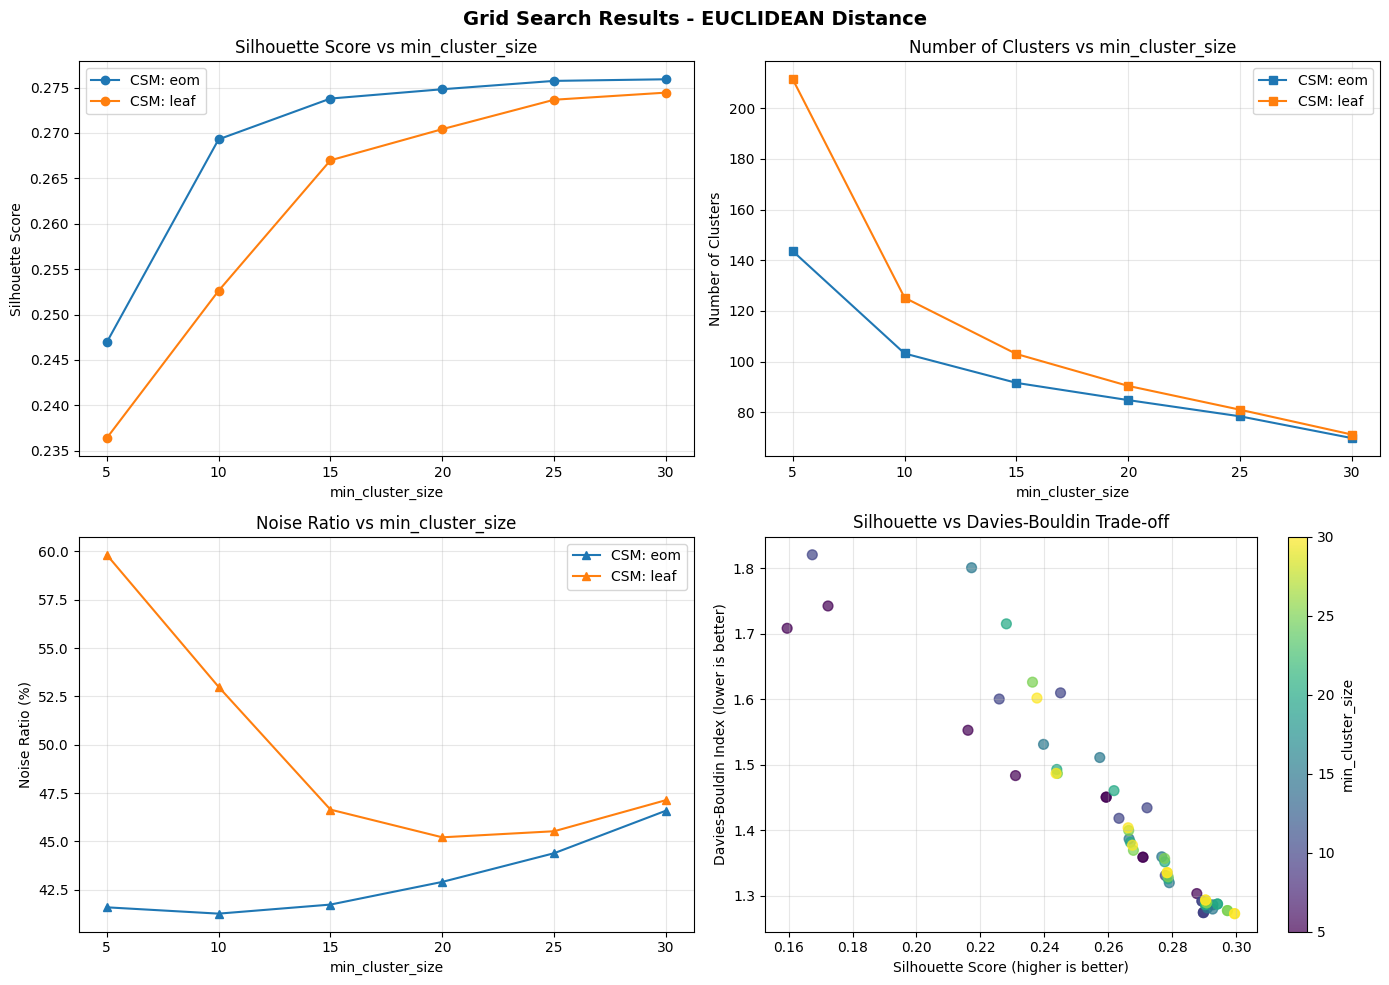

📊 Plot saved to: /content/drive/MyDrive/OTW S.KOM/Eksperiment/cluster_distribution.png


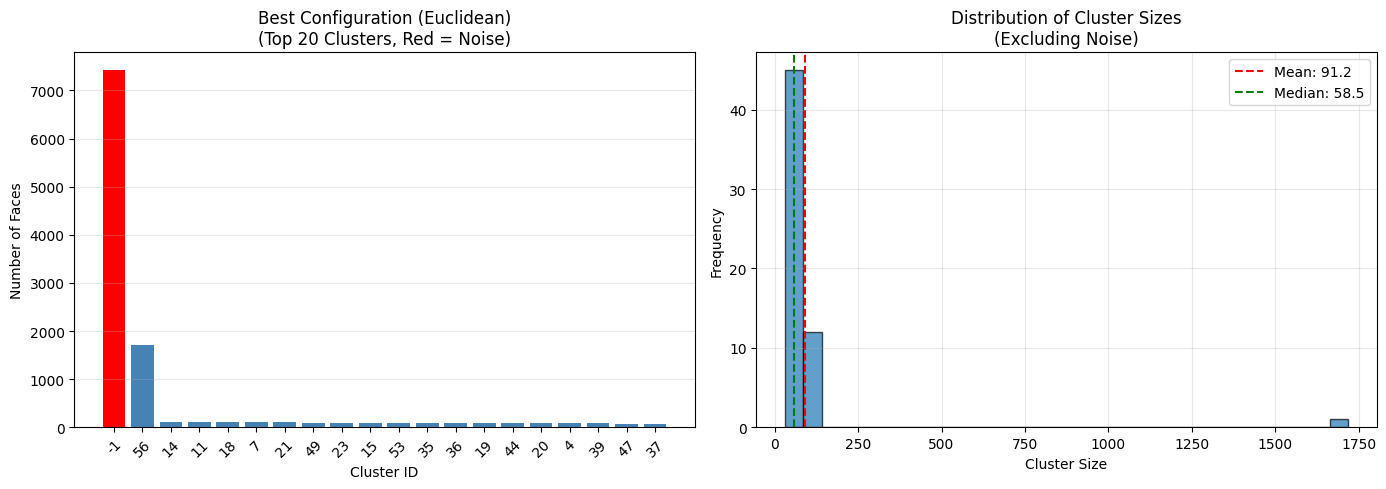

In [ ]:
def plot_grid_search_results(df, metric_name='euclidean'):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Grid Search Results - {metric_name.upper()} Distance', fontsize=14, fontweight='bold')

    # Filter valid results
    df_valid = df[df['silhouette_score'] != -1].copy()

    # Plot 1: Silhouette Score vs min_cluster_size
    ax1 = axes[0, 0]
    for csm in df_valid['cluster_selection_method'].unique():
        subset = df_valid[df_valid['cluster_selection_method'] == csm]
        grouped = subset.groupby('min_cluster_size')['silhouette_score'].mean()
        ax1.plot(grouped.index, grouped.values, marker='o', label=f'CSM: {csm}')
    ax1.set_xlabel('min_cluster_size')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score vs min_cluster_size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Number of Clusters vs min_cluster_size
    ax2 = axes[0, 1]
    for csm in df_valid['cluster_selection_method'].unique():
        subset = df_valid[df_valid['cluster_selection_method'] == csm]
        grouped = subset.groupby('min_cluster_size')['n_clusters'].mean()
        ax2.plot(grouped.index, grouped.values, marker='s', label=f'CSM: {csm}')
    ax2.set_xlabel('min_cluster_size')
    ax2.set_ylabel('Number of Clusters')
    ax2.set_title('Number of Clusters vs min_cluster_size')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Noise Ratio vs min_cluster_size
    ax3 = axes[1, 0]
    for csm in df_valid['cluster_selection_method'].unique():
        subset = df_valid[df_valid['cluster_selection_method'] == csm]
        grouped = subset.groupby('min_cluster_size')['noise_ratio'].mean()
        ax3.plot(grouped.index, grouped.values, marker='^', label=f'CSM: {csm}')
    ax3.set_xlabel('min_cluster_size')
    ax3.set_ylabel('Noise Ratio (%)')
    ax3.set_title('Noise Ratio vs min_cluster_size')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Silhouette vs Davies-Bouldin
    ax4 = axes[1, 1]
    scatter = ax4.scatter(
        df_valid['silhouette_score'],
        df_valid['davies_bouldin_index'],
        c=df_valid['min_cluster_size'],
        cmap='viridis',
        alpha=0.7,
        s=50
    )
    ax4.set_xlabel('Silhouette Score (higher is better)')
    ax4.set_ylabel('Davies-Bouldin Index (lower is better)')
    ax4.set_title('Silhouette vs Davies-Bouldin Trade-off')
    plt.colorbar(scatter, ax=ax4, label='min_cluster_size')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(OUTPUT_DIR, f'grid_search_results_{metric_name}.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"📊 Plot saved to: {plot_path}")

    plt.show()


def plot_cluster_distribution(labels, title="Cluster Size Distribution"):

    distribution = get_cluster_distribution(labels)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Bar chart (top 20 clusters)
    ax1 = axes[0]
    top_20 = distribution.head(20)
    colors = ['red' if cid == -1 else 'steelblue' for cid in top_20['cluster_id']]
    bars = ax1.bar(range(len(top_20)), top_20['count'], color=colors)
    ax1.set_xticks(range(len(top_20)))
    ax1.set_xticklabels([str(cid) for cid in top_20['cluster_id']], rotation=45)
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Number of Faces')
    ax1.set_title(f'{title}\n(Top 20 Clusters, Red = Noise)')
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: Histogram of cluster sizes (excluding noise)
    ax2 = axes[1]
    non_noise = distribution[distribution['cluster_id'] != -1]['count']
    ax2.hist(non_noise, bins=30, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Distribution of Cluster Sizes\n(Excluding Noise)')
    ax2.axvline(non_noise.mean(), color='red', linestyle='--', label=f'Mean: {non_noise.mean():.1f}')
    ax2.axvline(non_noise.median(), color='green', linestyle='--', label=f'Median: {non_noise.median():.1f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(OUTPUT_DIR, 'cluster_distribution.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"📊 Plot saved to: {plot_path}")

    plt.show()


# Generate visualizations
print("📊 Generating visualizations...")

# Plot grid search results
plot_grid_search_results(df_results_euclidean, metric_name='euclidean')

# Plot cluster distribution for best result
if best_result_euclidean:
    plot_cluster_distribution(
        best_result_euclidean['labels'],
        title=f"Best Configuration (Euclidean)"
    )

In [ ]:
def save_best_results(best_result, embeddings, metadata, output_dir, experiment_name):

    # Compile data untuk disimpan
    save_data = {
        'best_params': best_result['params'],
        'labels': best_result['labels'],
        'n_clusters': best_result['n_clusters'],
        'n_noise': best_result['n_noise'],
        'noise_ratio': best_result['noise_ratio'],
        'silhouette_score': best_result['silhouette_score'],
        'davies_bouldin_index': best_result['davies_bouldin_index'],
        'embeddings': embeddings,
        'metadata': metadata,
        'cluster_distribution': get_cluster_distribution(best_result['labels'])
    }

    # Save to pickle
    save_path = os.path.join(output_dir, f'{experiment_name}_best_result.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"💾 Best result saved to: {save_path}")

    # Print summary
    print("\n" + "=" * 60)
    print(f"📋 EXPERIMENT SUMMARY: {experiment_name}")
    print("=" * 60)
    print(f"\n🏆 Best Parameters:")
    print(f"   - min_cluster_size: {best_result['params']['min_cluster_size']}")
    print(f"   - min_samples: {best_result['params']['min_samples']}")
    print(f"   - metric: {best_result['params']['metric']}")
    print(f"   - cluster_selection_method: {best_result['params']['cluster_selection_method']}")
    print(f"\n📊 Results:")
    print(f"   - Number of clusters: {best_result['n_clusters']}")
    print(f"   - Noise points: {best_result['n_noise']} ({best_result['noise_ratio']:.2f}%)")
    print(f"   - Silhouette Score: {best_result['silhouette_score']:.4f}")
    print(f"   - Davies-Bouldin Index: {best_result['davies_bouldin_index']:.4f}")
    print("=" * 60)

    return save_path


# Save best results
if best_result_euclidean:
    save_path = save_best_results(
        best_result=best_result_euclidean,
        embeddings=embeddings,
        metadata=metadata,
        output_dir=OUTPUT_DIR,
        experiment_name='euclidean'
    )
else:
    print("⚠️ No valid best result to save!")

print("\n✅ Experiment 1 (Euclidean) Complete!")

💾 Best result saved to: /content/drive/MyDrive/OTW S.KOM/Eksperiment/euclidean_best_result.pkl

📋 EXPERIMENT SUMMARY: euclidean

🏆 Best Parameters:
   - min_cluster_size: 30
   - min_samples: None
   - metric: euclidean
   - cluster_selection_method: eom

📊 Results:
   - Number of clusters: 58
   - Noise points: 7425 (58.40%)
   - Silhouette Score: 0.2995
   - Davies-Bouldin Index: 1.2726

✅ Experiment 1 (Euclidean) Complete!
